# 1. Introduction

## Background

A Coffee (specialize in Kopi Luwak) company is looking for the best neighbourhood in Toronto where it consists of a low volume of coffee shops and high volume of neighbourhoods in a cluster. This allows the company to have a competitive edge over other competitors in term of providing their service to the coffee drinkers and give them less options(other coffee shop) to choose from . In this project, we will find the best location to set up a coffee shop using Foursquare location and weight the critera in order for the company to decide whether the area will be the best spot to set up a coffee shop.

## Interested Parties

As for the target audiences:
- Business owners who wish to find a place to start up their business.
- Coffee Lovers
- Coffee Manufacturers
- Food Delivery Services

## Description of the Data

For this project we need these following data:

## 1) Toronto City data that contains Borough, Neighborhoods along with there latitudes and longitudes

### Data Source: 

https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

### Description:

This Wikipedia page contain all the information we need to explore and cluster the neighborhoods in Toronto. We will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the Toronto dataset.

## 2)Geographical Location data using Geocoder Package

### Data Source: 
https://cocl.us/Geospatial_data

### Description: 
The second source of data provided us with the Geographical coordinates of the neighbourhoods with the respective Postal Codes.

## 3) Venue Data using Foursquare API

### Data Source: 
https://foursquare.com/developers/apps

### Description: 
From Foursquare API we can get the name,category,latitude,longitude for each venue.





## In this capstone project we are going to answer of these following major steps:

- Step 1: Scrape the data from the wikipedia page of Toronto.

- Step 2: Get the geographical coordinates of the neighborhoods using the Geocoder package.

- Step 3: Explore and cluster the neighborhoods in Toronto.

# Import Libraries

In [1]:
!conda install -c conda-forge beautifulsoup4 --yes

!conda install -c conda-forge geopy --yes

!conda install -c conda-forge folium=0.5.0 --yes

print('Libraries installed!')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries installed!


In [19]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns' , None)
pd.set_option('display.max_rows' , None)

import requests
import json
from pandas.io.json import json_normalize

from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

print("Libraries Imported")

Libraries Imported


# Scrape Neighborhoods Data

In [20]:
# open Wiki page with Beautiful Soup
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(data, 'html.parser')

In [21]:
# loop through table, grab each of the 3 columns shown
# Scrape the neighborhood data from the table in the wikipedia page of Toronto
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        # here we replace some symbols like "(" , ")" , "/" from the neighborhood name(Ex: (Parkview Hill / Woodbine Gardens))
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()


PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

# Data Pre-Processing

In [23]:
# save this dataframe in a CSV file
df.to_csv('Neighborhood Data.csv')

In [24]:

# drop rows having null value and value assigned as "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [25]:
# check for missing value
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [26]:

# Check if we still have any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [27]:

df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [28]:
# shape of dataframe
df.shape

(103, 3)

# Getting coordinates and add to the Toronto DataFrame

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In an older version of this course, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. Taking postal code M5G as an example, your code would look something like this:

Important Note: There is a limit on how many times you can call geocoder.google function. It is 2500 times per day. This should be way more than enough for you to get acquainted with the package and to use it to get the geographical coordinates of the neighborhoods in the Toronto.

GeoSpatial Dataset

Use the Geocoder package or the csv file to create the following dataframe: Important Note: There is a limit on how many times you can call geocoder.google function. It is 2500 times per day. This should be way more than enough for you to get acquainted with the package and to use it to get the geographical coordinates of the neighborhoods in the Toronto.

In [29]:

# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Merge the geographical dataframe with neighborhood dataframe according to the Postal Code

In [30]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [31]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

## Find all neighborhoods that contains "Toronto"  

In [32]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [33]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

# Explore and cluster the neighborhoods in Toronto


1. Add enough Markdown cells to explain what you decided to do andto report any observations you make.

2. Generate maps to visualize your neighborhoods and how they cluster together.

In [38]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.39715291165048


In [39]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

# Using Folium to generate a Map of Toronto with Boroughs markers(Top)

In [43]:

map_toronto = folium.Map(location = [lat_toronto,lon_toronto] , zoom_start = 11)

for lat,lon,post,borough,neigh in zip(df_toronto['Latitude'],df_toronto['Longitude'], df_toronto['PostalCode'], df_toronto['Borough'],df_toronto['Neighborhood']) :
    label = "{} ({}): {}".format(borough, post, neigh)
    popup = folium.Popup(label , parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_toronto)

map_toronto

# Next we will define Foursquare Credentials

In [44]:
CLIENT_ID = '4GEFWONNYSNFLFRDCRBKLNLM4G0KBM5ERQLEPUHEFAXJQP5U'
CLIENT_SECRET = 'JXSIHCONYV1UU0CTXXJPMRLHCUIPSBFTM32Q53EV3313X0IK'
# Set the Current Date (YYYYMMDD)
VERSION = '20210620'

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [47]:
toronto_venues.tail()

Neighborhood  \
1994  Mimico NW, The Queensway West, South of Bloor,...   
1995  Mimico NW, The Queensway West, South of Bloor,...   
1996  Mimico NW, The Queensway West, South of Bloor,...   
1997  Mimico NW, The Queensway West, South of Bloor,...   
1998  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
1994              43.628841              -79.520999   
1995              43.628841              -79.520999   
1996              43.628841              -79.520999   
1997              43.628841              -79.520999   
1998              43.628841              -79.520999   

                                      Venue  Venue Latitude  Venue Longitude  \
1994                                   RONA       43.629393       -79.518320   
1995                Jim & Maria's No Frills       43.631152       -79.518617   
1996  Koala Tan Tanning Salon & Sunless Spa       43.631370       -79.519006   
1997                          Value Village       43.631269       -79.518238   
1998                   Kingsway Boxing Club       43.627254       -79.526684   

              Venue Category  
1994          Hardware Store  
1995           Grocery Store  
1996           Tanning Salon  
1997  Thrift / Vintage Store  
1998                     Gym

Check how many venues are there per neighborhood

In [48]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               4   
Alderwood, Long Branch                                                  8   
Bathurst Manor, Wilson Heights, Downsview North                        20   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      22   
Berczy Park                                                            48   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           22   
CN Tower, King and Spadina, Railway Lands, Harb...                     17   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               8   
Central Bay Street                                                     64   
Christie                                                               15   
Church and Wellesley                                                   69   
Clairville, Humberwood, Woodbine Downs, West Hu...                      3   
Clarks Corners, Tam O'Shanter, Sullivan                                13   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             26   
Davisville North                                                       10   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         6   
Don Mills South                                                        18   
Dorset Park, Wexford Heights, Scarborough Town ...                      5   
Downsview Central                                                       3   
Downsview East                                                          4   
Downsview Northwest                                                     6   
Downsview West                                                          6   
Dufferin, Dovercourt Village                                           13   
Enclave of L4W                                                         14   
Enclave of M4L                                                         15   
Enclave of M5E                                                         83   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           66   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                5   
Garden District, Ryerson                                              100   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                         8   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          19   
Hillcrest Village                                                       5   
Humber Summit                                                           3   
Humberlea, Emery                                                        3   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         18   
Kennedy Park, Ionview, East Birchmount Park                             4   
Kensington Market, Chinatown, Grange Park                              57   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                

Check how many unique venues are there?

In [49]:

print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 263 uniques vanue categories.


In [50]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Fast Food Restaurant' 'Park' 'Bus Stop' 'Food & Drink Shop'
 'Hockey Arena' 'Portuguese Restaurant' 'Coffee Shop' 'Pizza Place'
 'Bakery' 'Distribution Center' 'Spa' 'Restaurant' 'Historic Site'
 'Farmers Market' 'Chocolate Shop' 'Performing Arts Venue'
 'Greek Restaurant' 'Dessert Shop' 'Breakfast Spot' 'Pub' 'Event Space'
 'Bank' 'Café' 'Sandwich Place' 'Theater' 'Asian Restaurant'
 'French Restaurant' 'Art Gallery' 'Beer Store' 'Mexican Restaurant'
 'Electronics Store' 'Discount Store' 'Hotel' 'Health Food Store'
 'Antique Shop' 'Boutique' 'Vietnamese Restaurant' 'Clothing Store'
 'Miscellaneous Shop' 'Furniture / Home Store' 'Accessories Store'
 "Women's Store" 'Carpet Store' 'Sushi Restaurant' 'Yoga Studio'
 'Burger Joint' 'Persian Restaurant' 'Diner' 'Japanese Restaurant'
 'Burrito Place' 'Salad Place' 'Bar' 'Gym' 'College Auditorium'
 'College Cafeteria' 'Music Venue' 'Caribbean Restaurant'
 'Athletics & Sports' 'Gastropub' 'Gym / Fitness Center' 'Phar

Check whether "Coffee Shop" exists in the location

In [51]:
"Coffee Shop" in toronto_venues['Venue Category'].unique()

True

# Data Analysis

Analyze venues in each area

In [52]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(1999, 264)


Neighborhoods  Accessories Store  Adult Boutique  Afghan Restaurant  \
0         Parkwoods                  0               0                  0   
1         Parkwoods                  0               0                  0   
2         Parkwoods                  0               0                  0   
3         Parkwoods                  0               0                  0   
4  Victoria Village                  0               0                  0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0        0                   0             0               0                0   
1        0                   0             0               0                0   
2        0                   0             0               0                0   
3        0                   0             0               0                0   
4        0                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0      0                0         0           0                   0       0   
1      0                0         0           0                   0       0   
2      0                0         0           0                   0       0   
3      0                0         0           0                   0       0   
4      0                0         0           0                   0       0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Bowling Alley  \
0           0              0          0         0              0   
1           0              0          0         0              0   
2           0              0          0         0              0   
3           0              0          0         0              0   
4           0              0          0         0              0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0      


Find the frequency of occurance of each category in an area

In [53]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(100, 264)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Adult Boutique  Afghan Restaurant  Airport  Airport Food Court  \
0             0.0                0.0      0.0                 0.0   
1             0.0                0.0      0.0                 0.0   
2             0.0                0.0      0.0                 0.0   
3             0.0                0.0      0.0                 0.0   
4             0.0                0.0      0.0                 0.0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0           0.0             0.0              0.0               0.0   
1           0.0             0.0              0.0               0.0   
2           0.0             0.0              0.0               0.0   
3           0.0             0.0              0.0               0.0   
4           0.0             0.0              0.0               0.0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0             0.000000           0.0       0.0          0.0   
1             0.000000           0.0       0.0          0.0   
2             0.000000           0.0       0.0          0.0   
3             0.000000           0.0       0.0          0.0   
4             0.045455           0.0       0.0          0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                  0.0               0.0                 0.0          0.0   
1                  0.0               0.0                 0.0          0.0   
2                  0.0               0.0                 0.0          0.0   
3                  0.0               0.0                 0.0          0.0   
4                  0.0               0.0                 0.0          0.0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0            0.0        0.0         0.0         0.0     0.0  0.00  0.0   
1            0.0        0.0         0.0         0.0     0.0  0.00  0.0   
2            0.0        0.0         0.0         0.0     0.0  0.10  0.0   
3            0.0        0.0         0.0         0.0     0.0  0.25  0.0   
4            0.0        0.0         0.0         0.0     0.0  0.00  0.0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0             0.0               0.0               0.0                 0.0   
1             0.0               0.0               0.0                 0.0   
2             0.0               0.0               0.0                 0.0   
3             0.0               0.0               0.0                 0.0   
4             0.0               0.0               0.0                 0.0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bistro  \
0    0.0              0.0       0.0         0.0                 0.0     0.0   
1    0.0              0.0       0.0         0.0                 0.0     0.0   
2    0.0              0.0       0.0         0.0                 0.0     0.0   
3    0.0              0.0       0.0         0.0                 0.0     0.0   
4    0.0              0.0       0.0         0.0                 0.0     0.0   

   Board Shop  Boat or Ferry  Bookstore  Boutique  Bowling Alley  \
0         0.0            0.0        0.0       0.0            0.0   
1         0.0            0.0        0.0       0.0            0.0   
2         0.0            0.0        0.0       0.0            0.0   
3         0.0            0.0        0.0       0.0            0.0   
4         0.0            0.0        0.0       0.0            0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0            0.25      0.0         0.00  


We only require the "Neighborhoods" and "Italian Restaurant" columns for the clustering

In [66]:
cs = to_grouped[["Neighborhoods","Coffee Shop"]]
cs.head()

Neighborhoods  Coffee Shop
0                                        Agincourt     0.000000
1                           Alderwood, Long Branch     0.125000
2  Bathurst Manor, Wilson Heights, Downsview North     0.100000
3                                  Bayview Village     0.000000
4                Bedford Park, Lawrence Manor East     0.090909

In [55]:
# rename column "Neighborhoods" to "Neighborhood"
cs = cs.rename(columns={'Neighborhoods':'Neighborhood'})

In [56]:

# drop "Neighborhood" column from the dataframe
X = cs.drop(['Neighborhood'], axis=1)

# Clustering

## Find the best K value using the Elbow Point method

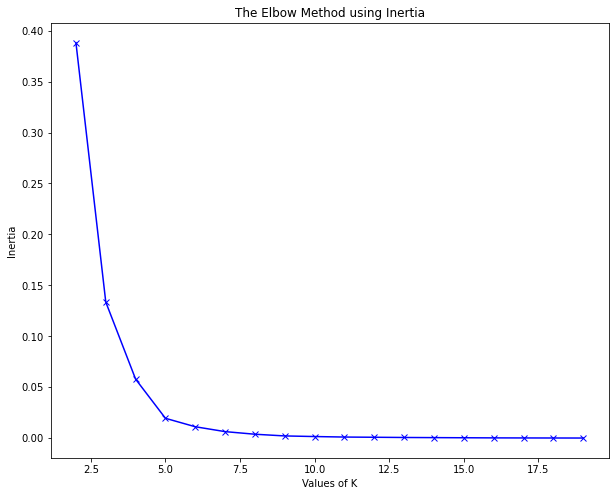

In [57]:
# find 'k' value by Elbow Method
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

The elbow point(turning point) has an optimized K value of 4 which means 4 clusters.

In [58]:
kclusters = 4

toronto_grouped_clustering = cs.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([1, 3, 3, 1, 3, 3, 1, 3, 3, 1], dtype=int32)

In [59]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

In [60]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = cs.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [61]:
to_merged.head()

Neighborhood  Coffee Shop  \
0                                        Agincourt     0.000000   
1                           Alderwood, Long Branch     0.125000   
2  Bathurst Manor, Wilson Heights, Downsview North     0.100000   
3                                  Bayview Village     0.000000   
4                Bedford Park, Lawrence Manor East     0.090909   

   Cluster Labels  
0               1  
1               3  
2               3  
3               1  
4               3

In [62]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1999, 9)


Neighborhood  Coffee Shop  Cluster Labels  Neighborhood Latitude  \
0               Agincourt        0.000               1              43.794200   
0               Agincourt        0.000               1              43.794200   
0               Agincourt        0.000               1              43.794200   
0               Agincourt        0.000               1              43.794200   
1  Alderwood, Long Branch        0.125               3              43.602414   

   Neighborhood Longitude                             Venue  Venue Latitude  \
0              -79.262029       Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                     El Pulgarcito       43.792648   
0              -79.262029                          Twilight       43.791999   
0              -79.262029                   Commander Arena       43.794867   
1              -79.543484  Il Paesano Pizzeria & Restaurant       43.601280   

   Venue Longitude             Venue Category  
0       -79.260203             Breakfast Spot  
0       -79.259208  Latin American Restaurant  
0       -79.258584                     Lounge  
0       -79.267989               Skating Rink  
1       -79.545028                Pizza Place

In [63]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(1999, 9)


Neighborhood  Coffee Shop  Cluster Labels  \
52                                  Leaside     0.107143               3   
52                                  Leaside     0.107143               3   
52                                  Leaside     0.107143               3   
17           Commerce Court, Victoria Hotel     0.140000               3   
15  Clarks Corners, Tam O'Shanter, Sullivan     0.076923               3   

    Neighborhood Latitude  Neighborhood Longitude           Venue  \
52              43.709060              -79.363452  Golden Griddle   
52              43.709060              -79.363452       SportChek   
52              43.709060              -79.363452    Sunset Grill   
17              43.648198              -79.379817        Crepe TO   
15              43.781638              -79.304302        Kub Khao   

    Venue Latitude  Venue Longitude       Venue Category  
52       43.708826       -79.362829       Breakfast Spot  
52       43.709854       -79.360455  Sporting Goods Shop  
52       43.710081       -79.362529       Breakfast Spot  
17       43.650063       -79.374587             Creperie  
15       43.780438       -79.299837      Thai Restaurant

 Check the exact number of Coffee Shop

In [64]:
to_merged['Venue Category'].value_counts()['Coffee Shop']

201

# Show those clusters onto a map

In [65]:

map_clusters = folium.Map(location=[lat, lon], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
for cluster in range(0,kclusters): 
    group = folium.FeatureGroup(name='<span style=\\"color: {0};\\">{1}</span>'.format(rainbow[cluster-1],cluster))
    for lat, lon, poi, label in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
        if int(label) == cluster: 
            label = folium.Popup('ORIG. '+ str(poi) + 'Cluster ' + str(cluster), parse_html=True)
            folium.CircleMarker(
                (lat, lon),
                radius=5,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7).add_to(group)
    group.add_to(map_clusters)
folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters)
map_clusters.save(outfile= "map_clusters.html")
map_clusters

# How many Neighborhoods per Cluster?

In [67]:

cs["Cluster Labels"] = kmeans.labels_
cs.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Neighborhoods  Coffee Shop  \
0                                        Agincourt     0.000000   
1                           Alderwood, Long Branch     0.125000   
2  Bathurst Manor, Wilson Heights, Downsview North     0.100000   
3                                  Bayview Village     0.000000   
4                Bedford Park, Lawrence Manor East     0.090909   

   Cluster Labels  
0               1  
1               3  
2               3  
3               1  
4               3

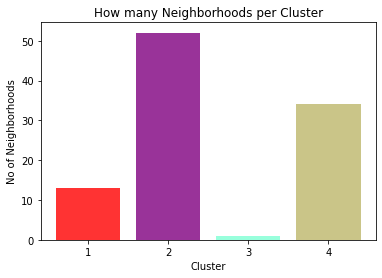

In [68]:

objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = cs['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [69]:

# How many neighborhoods in each cluster
cs['Cluster Labels'].value_counts()

1    52
3    34
0    13
2     1
Name: Cluster Labels, dtype: int64

In [70]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

# Analysis of every clustering

## Cluster 1 : North York

In [71]:

# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough               Neighborhood  Coffee Shop  Cluster Labels  \
0        North York           Victoria Village     0.250000               0   
1        North York           Victoria Village     0.250000               0   
2        North York           Victoria Village     0.250000               0   
3        North York           Victoria Village     0.250000               0   
4  Downtown Toronto  Regent Park, Harbourfront     0.166667               0   

   Neighborhood Latitude  Neighborhood Longitude                   Venue  \
0              43.725882              -79.315572  Victoria Village Arena   
1              43.725882              -79.315572              Pizza Nova   
2              43.725882              -79.315572             Tim Hortons   
3              43.725882              -79.315572               Portugril   
4              43.654260              -79.360636      Soulpepper Theatre   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.723481       -79.315635           Hockey Arena  
1       43.725824       -79.312860            Pizza Place  
2       43.725517       -79.313103            Coffee Shop  
3       43.725819       -79.312785  Portuguese Restaurant  
4       43.650780       -79.357615                Theater

## Cluster 2 : North York

In [72]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough    Neighborhood  Coffee Shop  Cluster Labels  \
0   North York       Parkwoods          0.0               1   
1   North York       Parkwoods          0.0               1   
2   North York       Parkwoods          0.0               1   
3   North York       Parkwoods          0.0               1   
4  Scarborough  Malvern, Rouge          0.0               1   

   Neighborhood Latitude  Neighborhood Longitude            Venue  \
0              43.753259              -79.329656    Variety Store   
1              43.753259              -79.329656   TTC stop #8380   
2              43.753259              -79.329656  Brookbanks Park   
3              43.753259              -79.329656              KFC   
4              43.806686              -79.194353          Wendy’s   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.751974       -79.333114     Food & Drink Shop  
1       43.752672       -79.326351              Bus Stop  
2       43.751976       -79.332140                  Park  
3       43.754387       -79.333021  Fast Food Restaurant  
4       43.807448       -79.199056  Fast Food Restaurant

## Cluster 3 :Scarborough

In [73]:

# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough Neighborhood  Coffee Shop  Cluster Labels  \
0  Scarborough       Woburn     0.666667               2   
1  Scarborough       Woburn     0.666667               2   
2  Scarborough       Woburn     0.666667               2   

   Neighborhood Latitude  Neighborhood Longitude               Venue  \
0              43.770992              -79.216917           Starbucks   
1              43.770992              -79.216917  Korean Grill House   
2              43.770992              -79.216917         Tim Hortons   

   Venue Latitude  Venue Longitude         Venue Category  
0       43.770037       -79.221156            Coffee Shop  
1       43.770812       -79.214502  Korean BBQ Restaurant  
2       43.770827       -79.223078            Coffee Shop

## Cluster 4 : North York

In [74]:

# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough                      Neighborhood  Coffee Shop  Cluster Labels  \
0  North York  Lawrence Manor, Lawrence Heights     0.076923               3   
1  North York  Lawrence Manor, Lawrence Heights     0.076923               3   
2  North York  Lawrence Manor, Lawrence Heights     0.076923               3   
3  North York  Lawrence Manor, Lawrence Heights     0.076923               3   
4  North York  Lawrence Manor, Lawrence Heights     0.076923               3   

   Neighborhood Latitude  Neighborhood Longitude                    Venue  \
0              43.718518              -79.464763               Le Château   
1              43.718518              -79.464763               Orfus Road   
2              43.718518              -79.464763   Imperial Carpet & Home   
3              43.718518              -79.464763              Fairweather   
4              43.718518              -79.464763  International Clothiers   

   Venue Latitude  Venue Longitude  Venue Category  
0       43.719269       -79.460276  Clothing Store  
1       43.719180       -79.460360  Clothing Store  
2       43.716672       -79.467415    Carpet Store  
3       43.717878       -79.467246   Women's Store  
4       43.717997       -79.466720  Clothing Store

# Number of neighborhoods per cluster vs Average number of Italian Restaurants in each Cluster

Text(0.5, 1.0, 'Average number of Coffee Shop per Cluster')

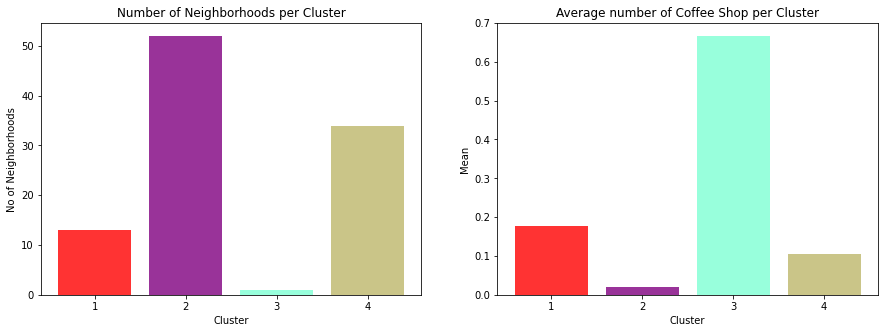

In [75]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = cs['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Coffee Shop per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Coffee Shop'].mean(),df_cluster2['Coffee Shop'].mean(),df_cluster3['Coffee Shop'].mean(),
                df_cluster4['Coffee Shop'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Coffee Shop per Cluster')

# Conclusion

Based on , these two bar charts show that the coffee shop (Kopi Luwak) is best to set-up in cluster 2 (North York) due to the high number of neighbourhood and least number of existing coffeeshop in the area. However, if the coffee shop owner is confident that his coffee has the competitive edge over other competitors in term of delivering the top-notch coffee breed and exclusive to those who feel appreciate for the quality, he may choose to opt for cluster 3 (Scarborough).

Using data visualization ,cleaning and extracting of data (information of Tornto) which we can showcase to our coffeeshop owner that we managed to find the highest volume of coffee shop in the Tornto and neighbourhoods through clustering. The purpose of clustering helps to determine a region where places which are nearby can be categorized together so that the data is more appealing and easier to understand as compared to several number of clusters with different names. With the presentation of this project, the coffee shop will gain a better understanding of where he can find the most strategized location to set up his store and ward off his competitors. 

# Future Work

These are some ideas which can improve the quality of this existing project:

1)	Apply different techniques of clustering algorithms for the neighbourhoods.

2)	Consider other features such as the food, market area and hotspot.

3)	Include more venues in a neighbourhood for better analysis through the use of Foursquare API.
